In [10]:
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import re
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
import os
os.chdir('C:/data')

In [11]:
rows = []
#compile函数根据一个模式字符串和可选的标志参数生成一个正则表达式对象。该对象拥有一系列方法用于正则表达式匹配和替换。
#+=表示两个值相加，然后返回值给符号左侧的变量
rx = re.compile('([0-9]+)[^;\n]+[;|\n]')
with open('times.txt') as f:
    for line in f:
        name,team,lid,pid,actions = line.split('\t')
        team = int(team)
        lid = int(lid)
        pid = int(pid)
        
        total_time = 0
        n_actions = 0
        for match in rx.finditer(actions):
            total_time += int(match.group(1))
            n_actions += 1
        rows.append([name, team, lid, pid, total_time, n_actions])
        
df = pd.DataFrame(rows, columns=['name','team','lid','pid','time','n_acts'])
df.head()

,name,team,lid,pid,time,n_acts
0,011i,0,1,11973,1458,7
1,011i,0,2,11974,159,4
2,011i,0,3,11975,396,6
3,011i,0,4,11976,178,5
4,135Mallos,0,1,8144,639,7


In [13]:
print(len(df))

22334


In [4]:
def bs_permute(dist1, dist2, func, size):
    distboth = np.concatenate((dist1,dist2))
    
    bs_samples = np.empty(size)
    for i in range(size):
        scrambled = np.random.permutation(distboth)
        perm1 = scrambled[:len(dist1)]
        perm2 = scrambled[len(dist1):]
        bs_samples[i] = func(perm1, perm2)
        
    return bs_samples

def diff_meds(dist1, dist2):
    return np.median(dist1) - np.median(dist2)
    
def test_median(dist1, dist2, size):
    gtruth_dmed = diff_meds(dist1, dist2)
    sample_dmeds = bs_permute(dist1, dist2, diff_meds, size)
    
    pval = np.sum(sample_dmeds >= gtruth_dmed) / len(sample_dmeds)
    return pval

In [5]:
lid_grouped = df.groupby('lid')

teams0 = {}
teams1 = {}
pvals0 = {}
pvals1 = {}
for lid in lid_grouped.groups.keys():
    df_lid = lid_grouped.get_group(lid)
    df_pid = df_lid.sort_values('pid').drop_duplicates('name') # only take first playthrough
    
    # separate teams
    team_group = df_pid.groupby('team')
    team0 = team_group.get_group(0)['time']
    team1 = team_group.get_group(1)['time']
    teams0[lid] = team0
    teams1[lid] = team1
    
    pval0 = test_median(team0, team1, 100000)
    pval1 = test_median(team1, team0, 100000)
    pvals0[lid] = pval0
    pvals1[lid] = pval1
    
    print(f'{lid} p0={pval0} p1={pval1}')
    
    # TODO
#     if lid>100:

1 p0=0.78891 p1=0.22682
2 p0=0.99694 p1=0.00427
3 p0=0.85143 p1=0.16683
4 p0=0.34753 p1=0.67948
5 p0=0.93065 p1=0.07575
6 p0=0.36677 p1=0.63962
7 p0=0.22044 p1=0.80289
8 p0=0.98946 p1=0.01098
9 p0=0.99623 p1=0.00376
10 p0=0.74117 p1=0.2566
11 p0=0.95069 p1=0.05016
12 p0=0.99882 p1=0.00098
13 p0=0.88373 p1=0.11828
14 p0=0.97483 p1=0.02532
15 p0=0.6679 p1=0.3395
16 p0=0.99716 p1=0.00266
17 p0=0.97083 p1=0.03062
18 p0=0.9102 p1=0.091
101 p0=0.82941 p1=0.17123
102 p0=0.82514 p1=0.17553
103 p0=0.86362 p1=0.13594


C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

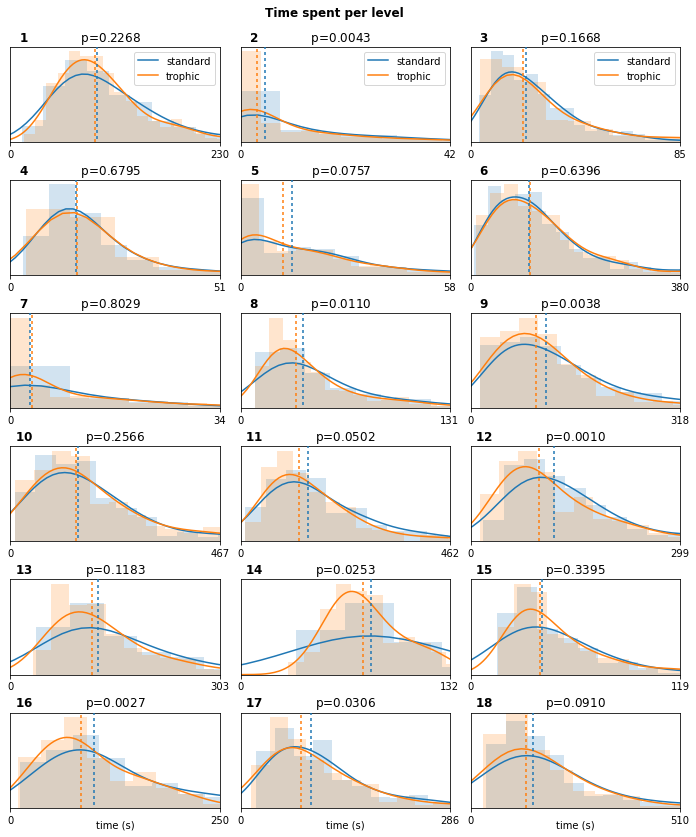

In [6]:
fig, axes = plt.subplots(nrows=6, ncols=3, figsize=(12,14))
plt.subplots_adjust(wspace=.1, hspace=.4)
cmap = plt.get_cmap('tab10')

for lid in teams0.keys():
    # choose axis
    i = lid-1
    if i>=100:
        continue
    
    team0 = teams0[lid]
    team1 = teams1[lid]
    pval1 = pvals1[lid]
    
    ax = axes[(i//3,i%3)]
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    
    conf0 = np.percentile(team0, [0,50,95])
#     conf1 = np.percentile(team1, [2.5,97.5])
    ax.set_xlim([0,conf0[2]])
    ax.set_xticks([0,conf0[2]])
    ax.set_xticklabels([0,int(conf0[2]/10)])
    
    sns.distplot(team1, ax=ax, hist_kws=dict(alpha=.2))
    sns.distplot(team0, ax=ax, hist_kws=dict(alpha=.2))

    if lid<=3:
        ax.legend(['standard','trophic'])
    
    med0 = np.median(team0)
    med1 = np.median(team1)
    
    ax.axvline(med0, color=cmap(.1), ls=(0,[2,2]), zorder=10)
    ax.axvline(med1, color=cmap(0), ls=(2,[2,2]), zorder=10)
    
    ax.set_title(r'$\bf{'+str(lid)+r'}$              p='+f'{pval1:.4f}                   ')
    ax.set_xlabel(' ')
    
for i in range(6):
    axes[i,0].set_ylabel('players')
for i in range(3):
    axes[5,i].set_xlabel('time (s)', labelpad=-5)

plt.margins(0,0)
fig.suptitle(r'Time spent per level', fontweight='bold', y=.92)
plt.savefig('C:/data/times/times.pdf', bbox_inches='tight', pad_inches=0)

In [7]:
# extract total time

grouped = df.groupby('name')
times = grouped['time'].sum()
teams = grouped['team'].first()
# progress = grouped['lid'].max()
# acts = grouped['n_acts'].sum()

times0 = []
times1 = []
# progress0 = []
# progress1 = []
for name in times.keys():
    if teams[name] == 0:
        times0.append(times[name])
#         progress0.append(progress[name])
    else:
        times1.append(times[name])
#         progress1.append(progress[name])

In [8]:
times_pval = test_median(times0, times1, 10000)
# stars_pval = test_median(stars0, stars1, 10000)
print(f'tp={times_pval}')

tp=0.0471


C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\94795\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'p = 0.0471')

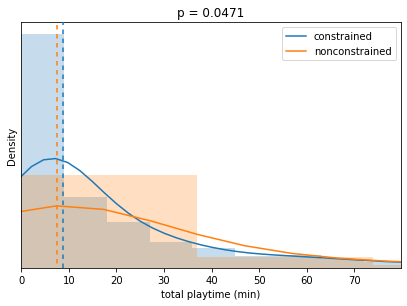

In [9]:
# plot histogram

fig,ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))
fig.tight_layout()

# hists
sns.distplot(times0, hist_kws=dict(alpha=.25), ax=ax)
sns.distplot(times1, hist_kws=dict(alpha=.25), ax=ax)

ax.legend(['constrained','nonconstrained'])
ax.set_xlabel('total playtime (min)')

# medians
cmap = plt.get_cmap('tab10')
tmed0 = np.median(times0)
tmed1 = np.median(times1)
ax.axvline(tmed0, color=cmap(0), ls=(0,[3,3]), zorder=10)
ax.axvline(tmed1, color=cmap(.1), ls=(3,[3,3]), zorder=10)


# ticks
ax.tick_params(axis='y', which='both', left=False, labelleft=False)

conf0 = np.percentile(times0, [0,50,95])
ax.set_xlim([0,conf0[2]])

xticks = list(range(0,42001,6000))
ax.set_xticks(xticks)
xticklabels = [int(tick/600) for tick in xticks]
ax.set_xticklabels(xticklabels)

ax.set_title(f'p = {times_pval}')